# Simple Linear Regression (Time Series Forecasting)
### The goal of Simple Linear Regression is to create a linear model that minimizes the sum of squares of residuals. The two main objectives are to establish if there is a relationship between two variables and to forecast new observations. 
### y = mx+c+e

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import matplotlib.dates as mdates

In [2]:
# Select * FROM bookings WHERE bookings.status = "Complete" and bookings.created_at < "2018-01-28" and bookings.created_at > "2017-01-01"  
df = pd.read_csv("/Users/ayush.LAPTOP-A9620OED/Downloads/bookings2018-01-28.csv", low_memory=False)

In [3]:
df.created_at = pd.to_datetime(df.created_at)
df.set_index(df.created_at, inplace=True)

In [4]:
# resampling works better for date indexes
# This is also because if there are no records for a particular day, this will create the day 
# but insert 0. When days are shifted or differentiated, it also makes sense because it will allow
# shifting appropriate days (ie, if shifted by 7, mondays will be shifted by monday).
dfCount = pd.DataFrame({'total_count' : df.resample('D').size()})

In [5]:
dfCount.head(5)

,total_count
created_at,
2017-01-01,5
2017-01-02,2
2017-01-03,3
2017-01-04,8
2017-01-05,5


In [6]:
dfCount.describe()

,total_count
count,392.000000
mean,208.653061
std,211.358393
min,0.000000
25%,46.000000
50%,131.500000
75%,274.000000
max,766.000000


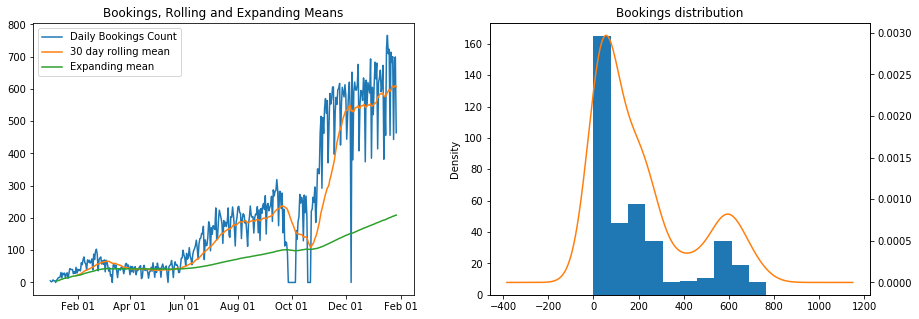

In [7]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize= (15,5))
ax[0].plot(dfCount, label="Daily Bookings Count")
ax[0].plot(dfCount.rolling(window=30).mean(), label='30 day rolling mean')
ax[0].plot(dfCount.expanding(min_periods=7).mean(), label='Expanding mean')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax[0].legend(loc='upper left')
dfCount.total_count.plot(kind='hist', ax=ax[1])
dfCount.total_count.plot(kind='kde', ax=ax[1], secondary_y=True)
ax[0].set_title("Bookings, Rolling and Expanding Means")
ax[1].set_title("Bookings distribution")
plt.show()

### Lag-K autocorrelation in a time series = correlation between values that are k periods apart. 
#### Auto correlation shows that the days closer are more correlated compared to further away. This data is not time independent.  

C:\Users\ayush.LAPTOP-A9620OED\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


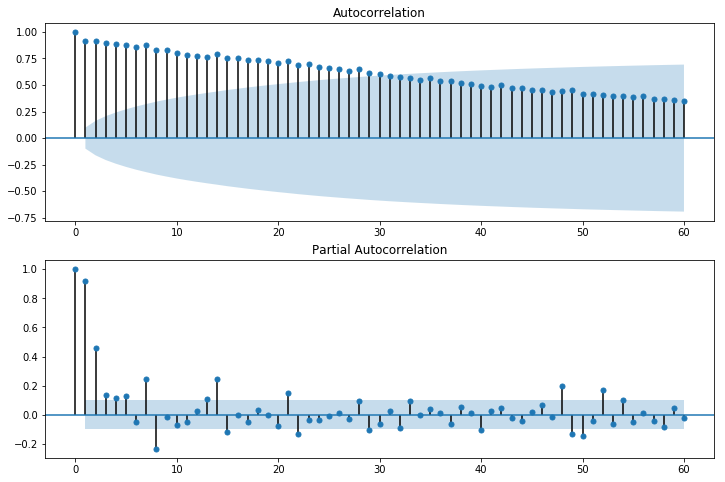

In [8]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dfCount.total_count, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dfCount.total_count, lags=60, ax=ax2)
plt.show()

#### Dashain, Tihar and Election days are resonsible for the dips. 

In [9]:
# Days where Tootle did not operate
# dfCountFiltered = dfCount[dfCount.total_count > 50]
# Although this looks tempting, it comes with a cost later. Maybe the right approach would be to fill out these instead.

dfCountFiltered = dfCount.copy()
dfCountFiltered.describe()

,total_count
count,392.000000
mean,208.653061
std,211.358393
min,0.000000
25%,46.000000
50%,131.500000
75%,274.000000
max,766.000000


## As It Is decomposition

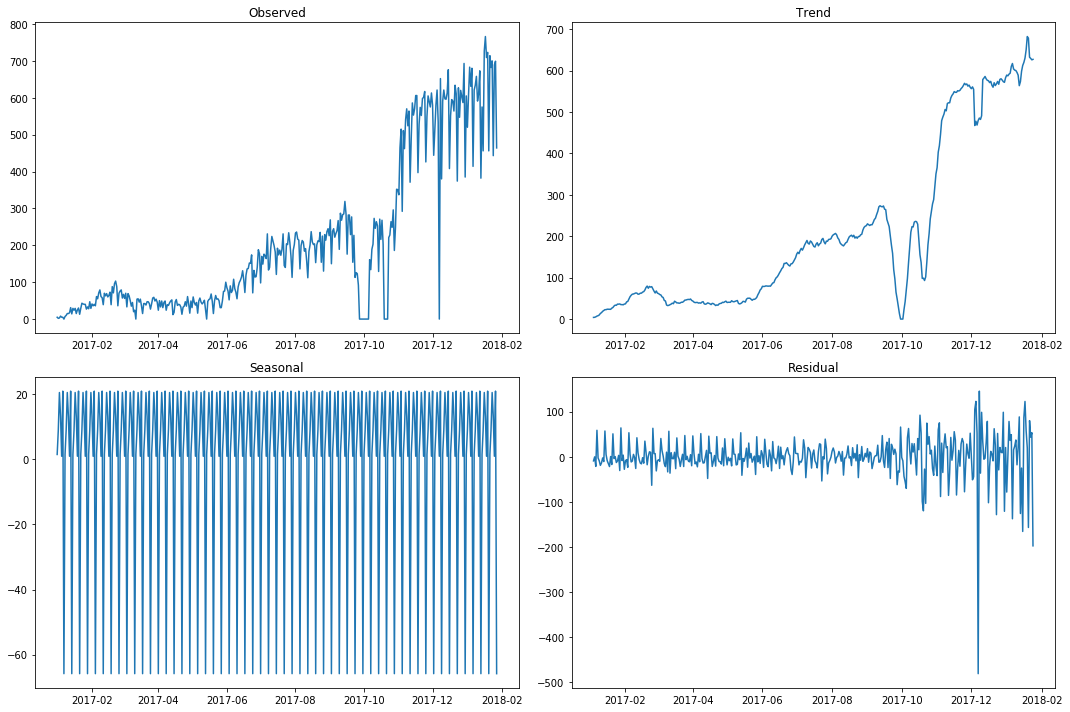

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

dfCountFiltered.interpolate(inplace = True)
decomposition = seasonal_decompose(dfCountFiltered, model = 'additive', freq=7)

fig, ax = plt.subplots(nrows = 2, ncols=2, figsize= (15,10))
ax[0 ,0].plot(decomposition.observed)
ax[0, 1].plot(decomposition.trend)
ax[1, 0].plot(decomposition.seasonal)
ax[1, 1].plot(decomposition.resid)
ax[0, 0].set_title("Observed")
ax[0, 1].set_title("Trend")
ax[1, 0].set_title("Seasonal")
ax[1, 1].set_title("Residual")
fig.tight_layout()
plt.show()

## Augmented Dickey-Fuller unit root test
### The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.
### Stationary Test
#### After trend and seasonality is removed, residual data can be checked for stationarity using Dickey Fuller unit root test)


#### A time series is stationary if, and only if, its mean does not depend on time, its variance is constant and also does not depend on time, and the autocorrelation does not vary either. This means that any time process with a trend and seasonality is not stationary. Trends can result in a varying mean over time, whereas seasonality can result in a changing variance over time, both which define a time series as being non-stationary. Stationary datasets are those that have a stable mean and variance, and are in turn much easier to model.

In [11]:
from statsmodels.tsa.stattools import adfuller
residual = decomposition.resid
residual.dropna(inplace=True)
print('p value: ', adfuller(residual.total_count, autolag = 'AIC', regression = 'ct')[1])

p value:  1.92556511464e-11


### P value is statistically significant. 

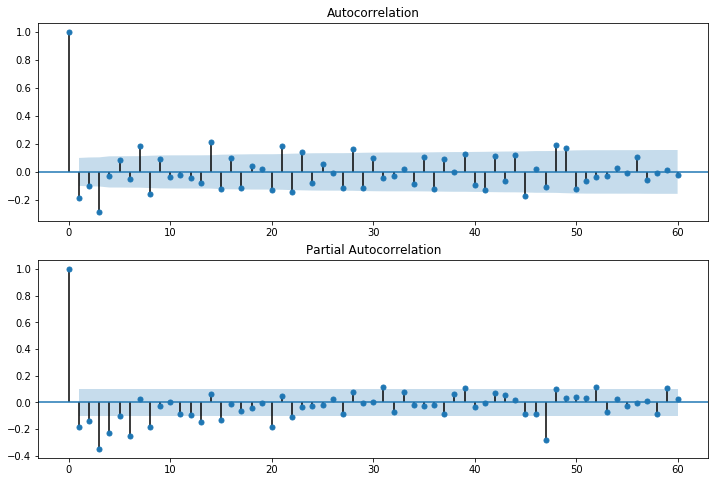

In [12]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(decomposition.resid, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(decomposition.resid, lags=60, ax=ax2)

In [13]:
# outliers (keeping data that are withing 3 std deviations from the mean)
# dfCountStdFiltered = dfCountFiltered[np.abs(dfCountFiltered.total_count-dfCountFiltered.total_count.mean())<=(3*dfCountFiltered.total_count.std())]
# again nothing changed here because did not want to get rid of dates on second thought
dfCountStdFiltered = dfCountFiltered.copy()
dfCountStdFiltered.describe()

,total_count
count,392.000000
mean,208.653061
std,211.358393
min,0.000000
25%,46.000000
50%,131.500000
75%,274.000000
max,766.000000


#### Nothing really changed here

## Detrending by Differencing
#### value(t) = observation(t) - observation(t-1)
#### This is a one to one mapping. This is necessary because we will have to retrofit trend back in the model.

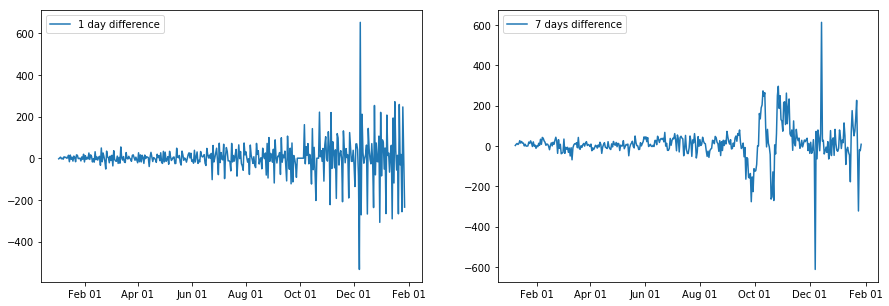

In [14]:
dfCountDiff1 = dfCountStdFiltered.diff(1)
# Basically differencing each day of the week with previous same day of the week
# Does not work because some days were removed completely
dfCountDiff7 = dfCountStdFiltered.diff(7)
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize= (15,5))
ax[0].plot(dfCountDiff1, label = "1 day difference")
ax[0].legend(loc='upper left')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax[1].plot(dfCountDiff7, label = "7 days difference")
ax[1].legend(loc='upper left')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.show()

## Detrending by Regression
#### value(t) = observation(t) - prediction(t)

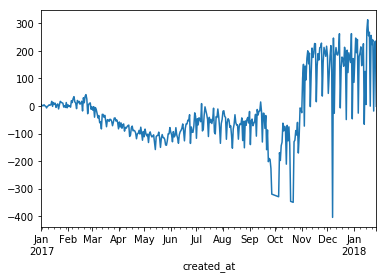

In [15]:
from statsmodels.regression.linear_model import OLS
model = OLS(dfCountStdFiltered.total_count.values, list(range(len(dfCountStdFiltered.values))))
result = model.fit()
result.params
fit = pd.Series(result.predict(list(range(len(dfCountStdFiltered.values)))), index = dfCountStdFiltered.index)

dfCount_detrended = dfCountStdFiltered.total_count - fit
dfCount_detrended.plot()
plt.show()

## Detrending by difference in Rolling Mean

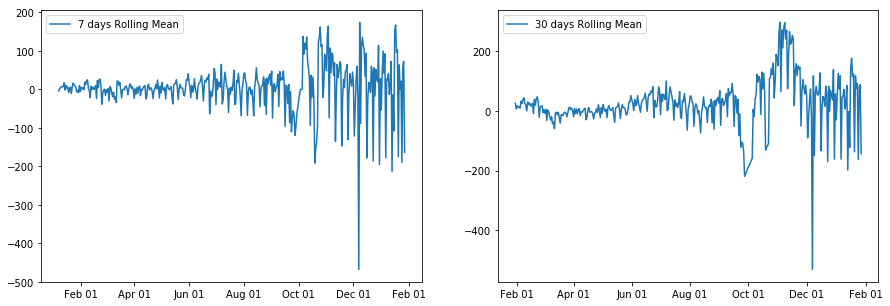

In [16]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize= (15,5))
ax[0].plot(dfCountStdFiltered - dfCountStdFiltered.rolling(window = 7).mean(), label = "7 days Rolling Mean")
ax[0].legend(loc='upper left')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax[1].plot(dfCountStdFiltered - dfCountStdFiltered.rolling(window = 30).mean(), label = "30 days Rolling Mean")
ax[1].legend(loc='upper left')
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.show()

In [17]:
dfCountStdFiltered.head()

,total_count
created_at,
2017-01-01,5
2017-01-02,2
2017-01-03,3
2017-01-04,8
2017-01-05,5


## Detrending by difference in Rolling Mean of Log values/SQRT values
#### A power or log transformation punishes larger values more than smaller values. Since we have 0 in our dataframe, lets use sqrt

In [18]:
dfCountStdFilteredSqrt = dfCountStdFiltered.apply(lambda x: np.sqrt(x))

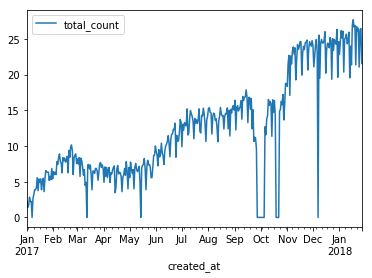

In [19]:
dfCountStdFilteredSqrt.plot()
plt.show()

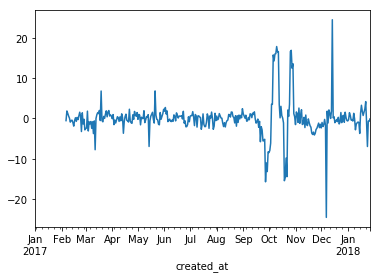

In [20]:
dfCountStdFilteredSqrt['trend_removed'] = dfCountStdFilteredSqrt.total_count - dfCountStdFilteredSqrt.total_count.rolling(window = 30).mean()
dfCountStdFilteredSqrt['seasonality_removed'] = dfCountStdFilteredSqrt.total_count - dfCountStdFilteredSqrt.total_count.shift(7)
dfCountStdFilteredSqrt['residual'] = dfCountStdFilteredSqrt.trend_removed - dfCountStdFilteredSqrt.trend_removed.shift(7)
dfCountStdFilteredSqrt.residual.plot()
plt.show()

In [21]:
dfCountStdFilteredSqrt.dropna(inplace=True)
print('p value: ', adfuller(dfCountStdFilteredSqrt.residual, autolag = 'AIC', regression = 'ct')[1])

p value:  0.000553162667868


### For our purposes, we will use detrending by rolling mean

In [22]:
dfCountStdFiltered['trend_removed'] = dfCountStdFiltered.total_count - dfCountStdFiltered.total_count.rolling(window = 30).mean()

In [23]:
dfCountStdFiltered['seasonality_removed'] = dfCountStdFiltered.total_count - dfCountStdFiltered.total_count.shift(7)

In [24]:
dfCountStdFiltered['residual'] = dfCountStdFiltered.trend_removed - dfCountStdFiltered.trend_removed.shift(7)

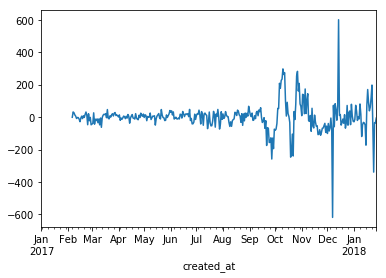

In [25]:
dfCountStdFiltered.residual.plot()
plt.show()

In [26]:
dfCountStdFiltered.dropna(inplace=True)
print('p value: ', adfuller(dfCountStdFiltered.residual, autolag = 'AIC', regression = 'ct')[1])

p value:  2.48580507424e-05


### Passes the stationary test

In [27]:
dfCountStdFiltered

,total_count,trend_removed,seasonality_removed,residual
created_at,,,,
2017-02-06,55,25.000000,8.0,-1.000000
2017-02-07,71,38.866667,42.0,31.666667
2017-02-08,79,44.566667,38.0,26.666667
2017-02-09,61,25.033333,25.0,13.233333
2017-02-10,58,20.600000,18.0,5.866667
2017-02-11,39,0.866667,3.0,-8.833333
2017-02-12,70,30.566667,9.0,-2.266667
2017-02-13,63,21.933333,8.0,-3.066667
2017-02-14,69,26.600000,-2.0,-12.266667


## Simple Linear Regression

In [28]:
from sklearn.linear_model import LinearRegression

In [29]:
model = LinearRegression().fit(dfCountStdFiltered.index.factorize()[0].reshape(-1,1), dfCountStdFiltered.residual)
m = model.coef_[0]
b = model.intercept_
print ('y = ', round(m, 5), 'x +', round(b ,2))

y =  -0.003 x + 0.62


In [30]:
predictions = model.predict(dfCountStdFiltered.index.factorize()[0].reshape(-1,1))

In [31]:
dfPredictions = pd.DataFrame(data=predictions, index=dfCountStdFiltered.index.values, columns=['predictions'])

In [32]:
dfPredictions.head()

,predictions
2017-02-06,0.620705
2017-02-07,0.617702
2017-02-08,0.614698
2017-02-09,0.611695
2017-02-10,0.608692


In [33]:
dfJoined = dfCountStdFiltered.join(dfPredictions, how = 'inner')

In [34]:
dfJoined.head()

,total_count,trend_removed,seasonality_removed,residual,predictions
created_at,,,,,
2017-02-06,55,25.000000,8.0,-1.000000,0.620705
2017-02-07,71,38.866667,42.0,31.666667,0.617702
2017-02-08,79,44.566667,38.0,26.666667,0.614698
2017-02-09,61,25.033333,25.0,13.233333,0.611695
2017-02-10,58,20.600000,18.0,5.866667,0.608692


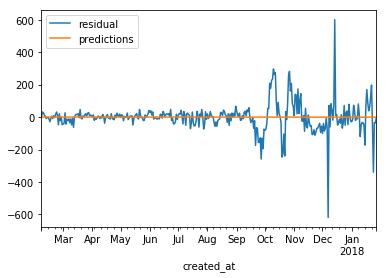

In [35]:
dfJoined[['residual', 'predictions']].plot()
plt.show()

In [36]:
model_LIB = LinearRegression().fit(decomposition.resid.index.factorize()[0].reshape(-1,1), decomposition.resid.total_count)
m_LIB = model_LIB.coef_[0]
b_LIB = model_LIB.intercept_
print ('y = ', round(m_LIB, 5), 'x +', round(b_LIB ,2))

y =  -0.00359 x + 0.47


In [37]:
predictionsLIB = model_LIB.predict(decomposition.resid.total_count.values.reshape(-1,1))

In [38]:
dfPredictions = pd.DataFrame(data=predictionsLIB, index=decomposition.resid.index.values, columns=['predictions_LIB'])

In [39]:
dfJoined2 = dfJoined.join(dfPredictions, how = 'inner')

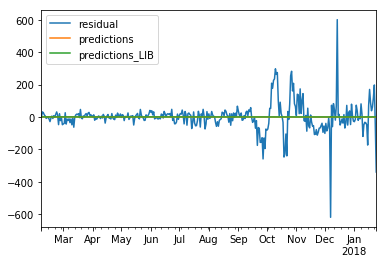

In [40]:
dfJoined2[['residual', 'predictions', 'predictions_LIB']].plot()
plt.show()

In [41]:
dfJoined2.head()

,total_count,trend_removed,seasonality_removed,residual,predictions,predictions_LIB
2017-02-06,55,25.000000,8.0,-1.000000,0.620705,0.514904
2017-02-07,71,38.866667,42.0,31.666667,0.617702,0.508131
2017-02-08,79,44.566667,38.0,26.666667,0.614698,0.454471
2017-02-09,61,25.033333,25.0,13.233333,0.611695,0.479917
2017-02-10,58,20.600000,18.0,5.866667,0.608692,0.566630


#### The point of adding linear regression from my model and from the model built by the library was to check for differences. They seem to overlap. Since the next step would be to retrofit trend and seasonality back, the mapping needs to be one to one. Not sure if one to one mapping can be used from data generated from the library since it seems more or less a blackbox at the moment. In my model however, since differences of the rolling mean and shiftting was used to remove trend and seasonality, it should be reversible. 

#### Lag-K autocorrelation in a time series = correlation between values that are k periods apart

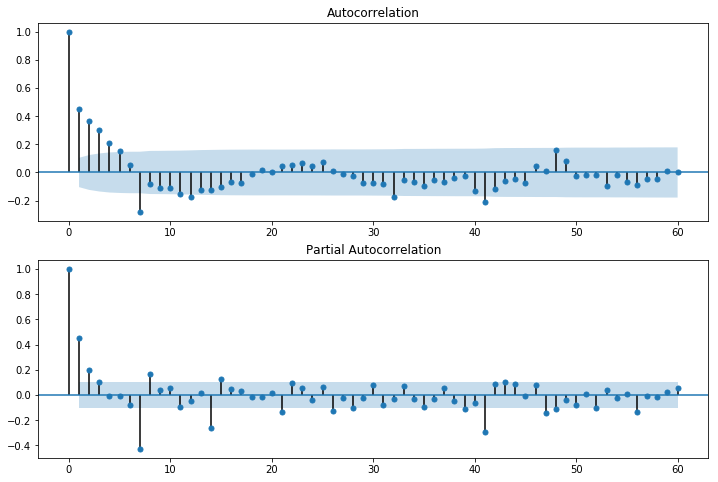

In [42]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dfJoined2.residual, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dfJoined2.residual, lags=60, ax=ax2)
plt.show()

In [43]:
from statsmodels.tsa.arima_model import ARIMA

### Research on what order of ARIMA to use in different cases

In [44]:
modelARIMA = ARIMA(dfCountStdFiltered.residual, order=(7,0,1))

In [45]:
model_fitARIMA = modelARIMA.fit(disp=0)
# print summary of fit model
print(model_fitARIMA.summary())

                              ARMA Model Results                              
Dep. Variable:               residual   No. Observations:                  356
Model:                     ARMA(7, 1)   Log Likelihood               -1988.617
Method:                       css-mle   S.D. of innovations             64.315
Date:                Mon, 29 Jan 2018   AIC                           3997.233
Time:                        09:29:44   BIC                           4035.983
Sample:                    02-06-2017   HQIC                          4012.647
                         - 01-27-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.1117      6.133     -0.018      0.985     -12.133      11.910
ar.L1.residual     0.0785      0.087      0.904      0.367      -0.092       0.249
ar.L2.residual     0.2529      0.053

In [52]:
# forecastARIMA = model_fitARIMA.forecast()
forecastARIMA = model_fitARIMA.forecast(steps=90)[0]

In [66]:
start_index = pd.datetime(2018, 1, 28)
end_index = pd.datetime(2018, 4, 27)
forecastARIMA = model_fitARIMA.predict(start=start_index, end=end_index)

In [67]:
dfARIMA = pd.DataFrame({'ARIMA' : model_fitARIMA.predict(start=start_index, end=end_index)})

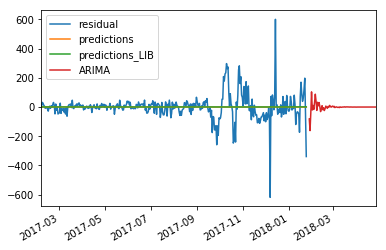

In [68]:
dfJoined2.append(dfARIMA)[['residual', 'predictions', 'predictions_LIB', 'ARIMA']].plot()
plt.show()

### TODO: Write inverse functions for trend and seasonality to get those back into the model.